# 模拟

## 原理

使用蒙特卡罗方法模拟，随机生成粒子和其径迹，根据径迹和探测器的交点$x$，在交点附近按设定的探测器分辨，按高斯分布随机取点$x'$。假设探测器效率为100%，所以5个探测器都有信号，根据得到的$x'$重新拟合径迹，拟合得到的径迹和探测器的新交点为$x''$，残差分布$\Delta x = x' - x''$。目的是让残差的分布的不确定度$\sigma_{\Delta x}$和之前分析得到的不确定度一致。

因为在探测器的探测中，x方向和y方向是独立的，所以对于模拟的任意粒子或者径迹，只需要考虑x或者y方向，即x和y分开模拟。模拟的径迹分布从已有数据拟合径迹中选择 k 和 b，然后做一点微小。



## 准备数据

模拟中需要探测器的z位置和残差的不确定度

| xz | yz | $\sigma_{\Delta x}$ | $\sigma_{\Delta y}$ |
| --- | --- | --- | --- |
| -1750.7 | -1742.1 | 0.336 | 0.365 |
| -1713.3 | -1721.9 | 0.365 | 0.375 |
| -1250.7 | -1242.1 | 0.399 | 0.425 |
| -1213.3 | -1221.9 | 0.405 | 0.415 |
| -381.6 | -373.4 | 0.202 | 0.234 |

在-1800 和 0 处生成生成需要遵循的分布

## 代码

### main.cpp

```c++
// main.cpp
#include "Simulation.h"
#include <ctime>

// detector data
const int DETECTORS = 5;
const int PARTICLES = 10000000;
// position
const Double_t xz[DETECTORS]{-1750.7, -1713.3, -1250.7, -1213.3, -381.6};
const Double_t yz[DETECTORS]{-1742.1, -1721.9, -1242.1, -1221.9, -373.4};
// resolution
const Double_t sx[DETECTORS]{0.336, 0.365, 0.399, 0.405, 0.2027};
const Double_t sy[DETECTORS]{0.365, 0.375, 0.425, 0.415, 0.2349};
// step
const int MAXRUN = 100;
const double eps = 1e-6;
const int MAXBATCH = 10;


int main(int argc, char **argv) {
	TFile *ipf = new TFile("../../data/tracking.root");
	TTree *ipt = (TTree*)ipf->Get("tree");

	Simulation *xSim = new Simulation;
	xSim->SetDetectors(DETECTORS, xz, sx);
	xSim->SetTraceGen(ipt, "kx", "bx");
	xSim->SetLog("../../log/xSimLog.root");
	xSim->AddNode(PARTICLES/100, 20, 1e-4, 1.0, 0.8);
	xSim->AddNode(PARTICLES/10, 40, 1e-5, 0.8, 0.8);
	xSim->AddNode(PARTICLES, 10, 1e-6, 0.1, 0.8);
	clock_t t = clock();
	xSim->Train(10);
	printf("%f s\n", float(clock()-t)/CLOCKS_PER_SEC);
	// xSim->Test(0, 3);
	delete xSim;

	Simulation *ySim = new Simulation;
	ySim->SetDetectors(DETECTORS, yz, sy);
	ySim->SetTraceGen(ipt, "ky", "by");
	ySim->SetLog("../../log/ySimLog.root");
	ySim->AddNode(PARTICLES/100, 20, 1e-4, 1.0, 0.8);
	ySim->AddNode(PARTICLES/10, 40, 1e-5, 0.8, 0.8);
	ySim->AddNode(PARTICLES, 10, 1e-6, 0.1, 0.8);
	ySim->Train(10);
	// ySim->Test(10);
	delete ySim;

	ipf->Close();
	return 0;
}


```

### Simulation.h

```c++
#include <TROOT.h>
#include <TFile.h>
#include <TTree.h>
#include <TRandom3.h>
#include <TH1D.h>
#include <TF1.h>
#include <TGraph.h>
#include <TString.h>
#include <vector>
#include <TH2I.h>

using std::vector;

// 模拟结果类
struct SimResult {
	Double_t Loss;
	Double_t *Res;
	int Particles;
	int Detectors;
};


// 模拟模型节点数据
struct SimNode {
	// physics
	int Particles;
	// iteration
	int MaxIter;
	Double_t Eps;
	// learning
	Double_t AlphaInit;
	Double_t ReduceAlpha;
};



// 模拟器类
class Simulation {
public:
	Simulation();
	~Simulation();
	// 设置探测器,
	// 	detN	探测器数量
	//	zz		探测器位置
	//	ss 		探测器目标残差
	int SetDetectors(int detN, const Double_t *zz, const Double_t *ss);
	// 设置径迹生成参数
	//	ipt 	径迹的树
	// 	sk 		树中径迹斜率k的branch名字
	//	sb 		树中径迹截距b的branch名字
	int SetTraceGen(TTree *ipt, const char* sk, const char *sb);
	// 设置输出
	//	fileName 输出文件名
	int SetLog(const char *fName = nullptr);
	// 设置模型节点
	// 	pp		粒子数量
	// 	maxIter	迭代次数
	// 	eps		迭代精度
	// 	aa 		初始学习率alpha
	// 	rr 		学习率衰减因子
	int AddNode(int pp, int maxIter, Double_t eps, Double_t aa, Double_t rr);
	// 开始拟合训练
	//  bb		训练组数
	int Train(int bb = 1);
	// 测试结果
	// 	bn		训练结果序号
	//  opf		输出文件
	//  cnt 	测试次数
	int Test(int bn, int cnt = 1);
private:
	int detectors;
	int particles;
	int batches;

	TRandom3 *gr;					// 随机数引擎
	TTree *tree;					// 用于随机径迹的数据
	Double_t rk, rb;				// “真实”径迹的k和b
	Double_t *z;					// 探测器的z平面
	Double_t *targetSigma;			// 目标残差的sigma

	vector<SimNode> nodes;			// 模型节点
	int nodeN;						// 节点总数
	int currentNode;				// 当前使用节点

	Double_t lastLoss;
	Double_t alpha;

	TFile *logFile;					// 记录的文件
	TTree *logTree;					// 记录的树
	Double_t minLoss;				// 记录的最小平方差
	Double_t *minRes;				// 记录的最接近的分辨

	int testNum;					// test id

	SimResult* results;				// 结果

	// 生成径迹
	int genTrace(Double_t *rp);
	// simple linear fit, return the chi2,
	Double_t sFit(Double_t *fx, Double_t *fy, Double_t &k, Double_t &b);
	// 模拟粒子打在探测器上，因为分辨位置偏移，利用偏移后的位置重建径迹，返回残差分布
	int hitAndTrace(Double_t *rp, Double_t *res, TH1D **hdp);
	// 拟合残差
	int fitResidual(TH1D **hdp, Double_t *ns);
	// 计算当前迭代的残差和目标残差的平方差
	Double_t lossFunc(Double_t *ns, Double_t rr = 0.8);
	// 根据学习率修改分辨用以下次迭代
	int step(Double_t *ns, Double_t *res);
	// 记录径迹
	int addTrace(TH2 *h, Double_t k, Double_t b, Double_t minBin = -1800.0, Double_t maxBin = 0.0);
};
```


### Simulation.cpp
```c++
#include "Simulation.h"


Simulation::Simulation() {
	gr = new TRandom3(0);

	detectors = 0;
	particles = 0;
	targetSigma = nullptr;
	z = nullptr;
	batches = 0;

	logFile = nullptr;
	logTree = nullptr;
	minLoss = 100.0;
	minRes = nullptr;

	nodeN = 0;
	nodes.clear();

	results = nullptr;

	testNum = 0;
}

Simulation::~Simulation() {
	if (gr) delete gr;

	if (z) delete[] z;
	if (targetSigma) delete[] targetSigma;

	if (minRes) delete[] minRes;
	if (logFile) logFile->Close();

	if (batches) {
		for (int i = 0; i != batches; ++i) {
			delete[] results[i].Res;
		}
		delete[] results;
	}
}

int Simulation::SetDetectors(int detN, const Double_t *zz, const Double_t *ss) {
	detectors = detN;
	targetSigma = new Double_t[detectors];
	z = new Double_t[detectors];
	for (int j = 0; j != detectors; ++j) {
		z[j] = zz[j];
		targetSigma[j] = ss[j];
	}
	return 0;
}


int Simulation::SetTraceGen(TTree *ipt, const char* sk, const char *sb) {
	tree = ipt;
	tree->SetBranchAddress(sk, &rk);
	tree->SetBranchAddress(sb, &rb);
	return 0;
}


int Simulation::AddNode(int pp, int maxIter, Double_t eps, Double_t aa, Double_t rr) {
	if (pp > particles) particles = pp;
	SimNode node;
	node.Particles = pp;
	node.MaxIter = maxIter;
	node.Eps = eps;
	node.AlphaInit = aa;
	node.ReduceAlpha = rr;
	nodes.push_back(node);
	nodeN++;
	return 0;
}


int Simulation::Train(int bb) {
	batches = bb;
	// result
	results = new SimResult[batches];
	for (int i = 0; i != batches; ++i) {
		results[i].Loss = 100.0;
		results[i].Res = new Double_t[detectors];
		results[i].Particles = particles;
		results[i].Detectors = detectors;
	}

	// variables
	Double_t *rp = new Double_t[particles*detectors];	// “真实”的位置,rp[particle][detector]
	Double_t *res = new Double_t[detectors];			// 当前的探测器分辨
	TH1D **hdp = new TH1D*[detectors];					// 当前的残差分布
	Double_t *ns = new Double_t[detectors];				// 当前的残差分布的sigma


	// log
	TGraph *gLoss = nullptr;
	TGraph **gRes = nullptr;


	for (int batch = 0; batch != batches; ++batch) {
		printf("\n============================================================\n");
		printf("batch %d:\n", batch);

		SimResult &result = results[batch];
		if (logFile) {
			logFile->cd();
			TString dirName;
			dirName.Form("batch%03d", batch);
			TDirectoryFile *dirBatch = new TDirectoryFile(dirName.Data(), dirName.Data());
			dirBatch->cd();
			gLoss = new TGraph;						// loss 变化
			gLoss->SetName(TString::Format("loss%03d", batch));
			gRes = new TGraph*[detectors];			// res 变化
			for (int j = 0; j != detectors; ++j) {
				gRes[j] = new TGraph;
				gRes[j]->SetName(TString::Format("res%d_%03d", j, batch));
			}
		}


		// generate the trace and the position on the detectors
		genTrace(rp);
		// random init resolution
		for (int j = 0; j != detectors; ++j) {
			res[j] = gr->Uniform(0.2, 0.6);
			result.Res[j] = res[j];
		}


		currentNode = 0;
		for (auto iter = nodes.begin(); iter != nodes.end(); ++iter) {
			alpha = iter->AlphaInit;
			for (int iteration = 0; iteration != iter->MaxIter; ++iteration) {
				hitAndTrace(rp, res, hdp);
				fitResidual(hdp, ns);
				Double_t loss = lossFunc(ns, iter->ReduceAlpha);
				if (logFile) {
					gLoss->SetPoint(iteration, iteration, loss);
					for (int j = 0; j != detectors; ++j) {
						gRes[j]->SetPoint(iteration, iteration, res[j]);
					}
				}
				if (loss < result.Loss) {
					result.Loss = loss;
					for (int j = 0; j != detectors; ++j) {
						result.Res[j] = res[j];
					}
				}
				if (loss < iter->Eps) break;
				step(ns, res);
				printf("batch %d, node %d, iteration %d, loss %lf\n", batch, currentNode, iteration, loss);
			}
			currentNode++;
			printf("------------------------------------------------------------\n");
		}


		// print result
		printf("\n");
		for (int j = 0; j != detectors-1; ++j) {
			printf("%lf, ", result.Res[j]);
		}
		printf("%lf\n\n", result.Res[detectors-1]);


		if (logFile) {
			if (gLoss) {
				gLoss->Write();
				delete gLoss;
			}
			if (gRes) {
				for (int j = 0; j != detectors; ++j) {
					gRes[j]->Write();
					delete gRes[j];
				}
				delete[] gRes;
			}
			if (logTree) {
				minLoss = result.Loss;
				for (int j = 0; j != detectors; ++j) {
					minRes[j] = result.Res[j];
				}
				logTree->Fill();
			}
		}
	}

	if (logTree) {
		logFile->cd();
		logTree->Write();
	}

	delete[] res;
	delete[] hdp;
	delete[] rp;
	delete[] ns;

	for (int i = 0; i != batches; ++i) {
		printf("\nLoss %lf,  Particles %d,  Detecotrs %d\n", results[i].Loss, results[i].Particles, results[i].Detectors);
		printf("Res\n");
		for (int j = 0; j != detectors; ++j) {
			printf("%lf ", results[i].Res[j]);
		}
		printf("\b\n");
	}

	return 0;
}




int Simulation::Test(int bn, int cnt) {
	Double_t *rp = new Double_t[particles*detectors];	// “真实”的位置,rp[particle][detector]
	TH1D **hdp = new TH1D*[detectors];					// 当前的残差分布
	Double_t *ns = new Double_t[detectors];				// 当前的残差分布的sigma
	Double_t loss;

	TTree *opt = nullptr;
	TDirectoryFile *testDir = nullptr;
	if (logFile) {
		TString dirName;
		dirName.Form("test%d", testNum);
		testDir = new TDirectoryFile(dirName.Data(), dirName.Data());
		testDir->cd();
		opt = new TTree("tree", "log of test");
		opt->Branch("loss", &loss, "loss/D");
		opt->Branch("sigma", ns, TString::Format("sigma[%d]/D", detectors));
	}

	AddNode(particles, 0, 1e-6, 0.0, 0.0);
	for (int i = 0; i != cnt; ++i) {
		printf("\n============================================================\n");
		printf("batch %d, test %d:\n", bn, i);
		if (logFile) {
			logFile->cd();
			if (testDir) testDir->cd();
			if (opt) opt->Fill();
			TString dirName;
			dirName.Form("subTest%02d", i);
			TDirectoryFile *subDir = new TDirectoryFile(dirName.Data(), dirName.Data());
			subDir->cd();
		}

		genTrace(rp);
		hitAndTrace(rp, results[bn].Res, hdp);
		// save hdp
		if (logFile) {
			for (int j = 0; j != detectors; ++j) {
				hdp[j]->Write();
			}
		}
		fitResidual(hdp, ns);
		loss = lossFunc(ns);

		printf("\ntest %d loss %lf\n\n", i, loss);
		printf("| target   | present  | resolution |\n");
		printf("| -------- | -------- | -----------|\n");
		for (int j = 0; j != detectors; ++j) {
			printf("| %lf | %lf | %lf   |\n", targetSigma[j], ns[j], results[bn].Res[j]);
		}

	}

	if (logFile && testDir && opt) {
		logFile->cd();
		testDir->cd();
		opt->Write();
	}



	delete[] hdp;
	delete[] ns;
	delete[] rp;

	testNum++;
	return 0;
}

int Simulation::SetLog(const char *opf) {
	if (!opf) return -1;
	if (!detectors) return -1;
	logFile = new TFile(opf, "recreate");
	logTree = new TTree("tree", "log of training");
	minRes = new Double_t[detectors];
	logTree->Branch("res", minRes, TString::Format("res[%d]/D", detectors));
	logTree->Branch("loss", &minLoss, "loss/D");
	return 0;
}


// 模拟生成径迹并计算径迹和探测器的交点
int Simulation::genTrace(Double_t *rp) {
	// log trace 记录“真实”径迹
	TH2I *hTrace = nullptr;
	if (logFile) {
		hTrace = new TH2I("hTrace", "trace for 'real' particles", 220, -2000.0, 200.0, 300, -150, 150);
	}

	Long64_t nentries = tree->GetEntriesFast();
	Long64_t jentry = nentries * gr->Uniform(0, 1);
	fprintf(stderr, "generating    0%%");
	for (int i = 0; i != particles; ++i) {
		tree->GetEntry(jentry);
		rk = gr->Gaus(rk, rk/300.0);
		rb = gr->Gaus(rb, rb/300.0);
		for (int j = 0; j != detectors; ++j) {
			rp[i*detectors+j] = rk * z[j] + rb;			// “真实”位置
		}
		jentry++;
		jentry = jentry > nentries ? 0 : jentry;
		if (logFile) {
			addTrace(hTrace, rk, rb, -1800.0, 0.0);
		}
		if ((i+1) % (particles/100) == 0) fprintf(stderr, "\b\b\b\b%3d%%", (i+1) / (particles/100));
		fflush(stderr);
	}
	fprintf(stderr, "\n");
	if (logFile) {
		hTrace->Write();
		if (hTrace) delete hTrace;
	}
	return 0;
}


// 线性拟合
Double_t Simulation::sFit(Double_t *fx, Double_t *fy, Double_t &k, Double_t &b) {
	int n = detectors;
	Double_t sumx = 0.0;
	Double_t sumy = 0.0;
	Double_t sumxy = 0.0;
	Double_t sumx2 = 0.0;
	for (int i = 0; i != n; ++i) {
		Double_t x = fx[i];
		Double_t y = fy[i];
		sumx += x;
		sumy += y;
		sumxy += x * y;
		sumx2 += x * x;
	}
	Double_t dn = Double_t(n);
	k = (sumxy - sumx*sumy/dn) / (sumx2 - sumx*sumx/dn);
	b = (sumy - k*sumx) / dn;
	Double_t chi2 = 0.0;
	for (int i = 0; i != n; ++i) {
		Double_t x = fx[i];
		Double_t y = fy[i];
		Double_t t = y - k*x - b;
		chi2 += t * t;
	}
	return chi2;
}


// 模拟粒子打在探测器上，根据分辨产生信号，根据信号重建径迹
int Simulation::hitAndTrace(Double_t *rp, Double_t *res, TH1D **hdp) {
	for (int j = 0; j != detectors; ++j) {
		TString name;
		name.Form("hdp%d", j);
		hdp[j] = new TH1D(name.Data(), name.Data(), 200, -1, 1);
	}

	int pp = nodes[currentNode].Particles;
	// hit and trace
	Double_t *vp = new Double_t[detectors];
	for (int i = 0; i != pp; ++i) {
		for (int j = 0; j != detectors; ++j) {
			vp[j] = gr->Gaus(rp[i*detectors+j], res[j]);			// hit and bring resolution
		}
		Double_t k, b;
		sFit(z, vp, k, b);
		// if (sFit((Double_t*)z, (Double_t*)vp, k, b) >= CHI_THRESHOLD) continue;			// no need, the chi2 is very small
		for (int j = 0; j != detectors; ++j) {
			Double_t tp = b + k * z[j];			// 用径迹拟合的位置
			hdp[j]->Fill(vp[j]-tp);					// 填充残差
		}
	}
	delete[] vp;
	return 0;
}



// 拟合残差，hdp被拟合的分布，ns拟合结果sigma
int Simulation::fitResidual(TH1D **hdp, Double_t *ns) {
	TF1 *f1 = new TF1("f1", "gaus", -0.6, 0.6);
	for (int j = 0; j != detectors; ++j) {
		hdp[j]->Fit(f1, "QRN");
		ns[j] = f1->GetParameter(2);
	}
	delete f1;
	for (int j = 0; j != detectors; ++j) {
		delete hdp[j];
	}
	return 0;
}



// 计算loss函数，ns - 当前残差sigma，rr - 学习率衰变因子
Double_t Simulation::lossFunc(Double_t *ns, Double_t rr) {
	Double_t l = 0.0;
	for (int j = 0; j != detectors; ++j) {
		Double_t t = ns[j] - targetSigma[j];
		l += t * t;
	}
	if (l > lastLoss) {
		alpha *= rr;
	}
	lastLoss = l;
	return l;
}


// 根据结果修改分辨率
int Simulation::step(Double_t *ns, Double_t *res) {
	for (int j = 0; j != detectors; ++j) {
		Double_t t = targetSigma[j] - ns[j];
		res[j] += alpha * t;
	}
	return 0;
}


int Simulation::addTrace(TH2 *h, Double_t k, Double_t b, Double_t minBin, Double_t maxBin) {
	if (!h) return -1;
	if (minBin >= maxBin) return -1;
	const int step = 10;
	for (int i = minBin; i < maxBin; i += step) {
		h->Fill(i, Int_t(i*k+b));
	}
	return 0;
}

```

## 一点注释

首先要对模拟器要大概的认识，这里使用的是一次模拟中多次迭代的模拟方法。模拟器其实相当于把输入加工成输出的东西，输入就是一组探测器的分辨率，输出就是该分辨率下的残差的 $\sigma$ ，模拟的目的是让这组 $\sigma$ 和数据中心的 $\sigma$ 相同。那么一个简单的思想就是，计算得到的 $\sigma$ 小了，就调大分辨率，得到的 $\sigma$ 大了，就调小分辨率。调整的大小呢，就由 $\sigma$ 和目标 $\sigma$ 的距离决定，距离远了，就多调点，步子迈大点，距离近了，就一点一点调。所以可以借用机器学习中 Loss 函数和学习率 $\alpha$ 的概念，以此为依据定量调整分辨率。所以模拟器中一次模拟包含多次迭代，经过试验，对于随机的初值，大概70-100次迭代后稳定在一个值附近波动。下面将解释每一次迭代中各个函数干了什么。

模拟首先需要生成径迹

### genTrace

生成“真实”的径迹
+ 从树中随机一个entry，从该entry开始连续读取粒子数个entry，读取其中的径迹的斜率k和截距b
+ 对k和b增加一点随机偏移
+ 根据k和b生成径迹，生成和探测器的交点位置
+ 如果设置了记录文件，将记录生成的径迹

生成的径迹如下图


In [1]:
TCanvas *c1 = new TCanvas;

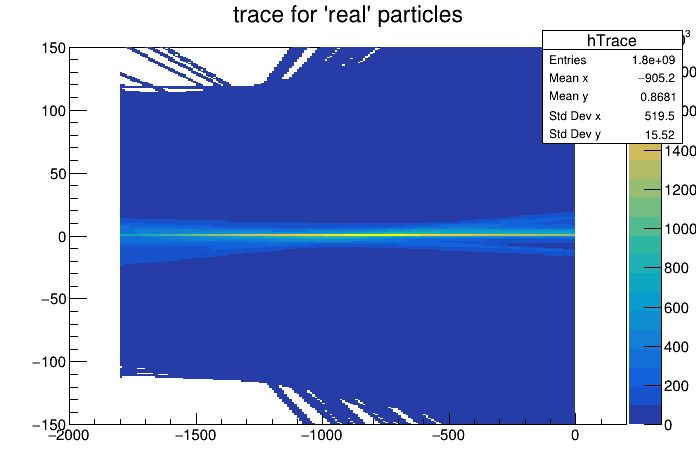

In [2]:
TFile *logFile = new TFile("../log/xSimLog.root");
TH2I *xTrace = (TH2I*)gDirectory->Get("batch000/hTrace");
xTrace->Draw("colz");
c1->Draw();

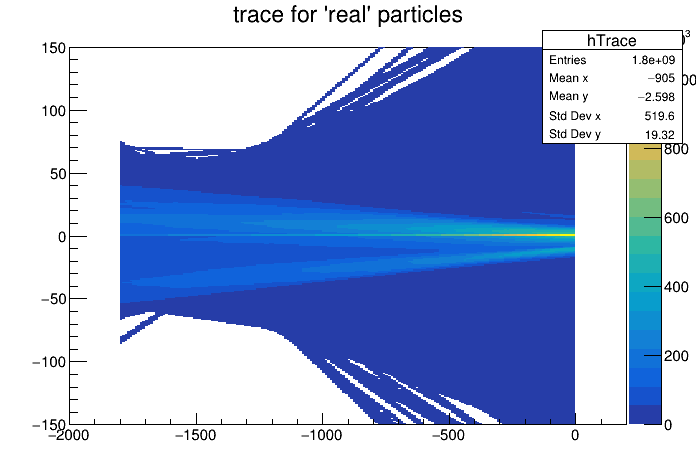

In [3]:
TFile *logFile = new TFile("../log/ySimLog.root");
TH2I *xTrace = (TH2I*)gDirectory->Get("batch000/hTrace");
xTrace->Draw("colz");
c1->Draw();

可见模拟的径迹和真实径迹相近。


### hitAndTrace
得到径迹和径迹与探测器的交点后，模拟探测器因为各种原因信号产生的点和原来不一样（即有分辨），然后和非模拟过程一样，根据信号点重建径迹，再计算残差。模拟分辨率过程不需要考虑探测效率，所以不需要重建策略。

+ 根据设定的分辨对“真实”位置进行偏移
+ 根据偏移的位置拟合径迹
+ 计算残差，并填入残差分布直方图

### fitResidual

得到残差的分布后，进行高斯拟合得到 $\sigma$

### lossFunc

这是走向高效自动模拟的重要一步，借用了机器学习中Loss函数的概念，这里定义的就是残差的$\sigma$和目标残差的$\sigma$的差的平方和，即当前设定的分辨下的残差$\sigma$和目标残差$\sigma$的距离。除了计算Loss函数，还调整了$\alpha$即学习率的值，如果Loss相比上一次迭代变大了，学习率需要衰减，这也是从机器学习中借鉴来的，反正能用。

+ 计算Loss，即`fitResidual`得到的残差 $\sigma$ 和目标残差的 $\sigma$ 的差的平方和
+ 根据Loss的变化改变 $\alpha$

### step

Loss 的值只是用于监测迭代的进度，用以判断迭代是否在朝目标前进。所以这一步其实紧接着`fitResidual`，和`lossFunc`是平行的。根据 $\sigma$ 和目标 $\sigma$ 的对比，调整分辨率。

$$
resolution_{next} = resolution_{present} + \alpha \cdot (\sigma_{target} - \sigma_{present}) 
$$




## 结果

模拟的多组结果都接近目标，以下选取最接近的几组

### x方向

| id  | particles | chi2 | PPAC1a | PPAC1b | PPAC2a | PPAC2b | PPAC3 |
| --- | --------- | ---- | ------ | ------ | ------ | ------ | ----- |
| 1 | 1e7 | 7e-6 | 0.387052 | 0.473400 | 0.420944 | 0.422365 | 0.753609 |
| 2 | 1e7 | 8e-6 | 0.387503 | 0.473718 | 0.420949 | 0.422820 | 0.750888 |
| 3 | 1e7 | 8e-6 | 0.387904 | 0.473732 | 0.421724 | 0.422807 | 0.749282 |

所以探测器的分辨率为

| PPAC1a | PPAC1b | PPAC2a | PPAC2b | PPAC3  |
| ------ | ------ | ------ | ------ | -----  |
| 0.387 $\pm$ 0.001 | 0.473 $\pm$ 0.001  | 0.421 $\pm$ 0.001  | 0.422 $\pm$ 0.001 | 0.752 $\pm$ 0.002 | 


### y方向

| id  | particles | chi2 | PPAC1a | PPAC1b | PPAC2a | PPAC2b | PPAC3 |
| --- | --------- | ---- | ------ | ------ | ------ | ------ | ----- |
| 1 | 1e7 | 8e-6 | 0.420599 | 0.460170 | 0.408184 | 0.377789 | 1.091719 |
| 2 | 1e7 | 9e-6 | 0.420645 | 0.460025 | 0.408890 | 0.378349 | 1.089135 |
| 3 | 1e7 | 8e-6 | 0.420560 | 0.460607 | 0.408415 | 0.377882 | 1.092117 |

即

| PPAC1a | PPAC1b | PPAC2a | PPAC2b | PPAC3  |
| ------ | ------ | ------ | ------ | -----  |
| 0.421 $\pm$ 0.001 | 0.460 $\pm$ 0.001  | 0.408 $\pm$ 0.001  | 0.377 $\pm$ 0.001 | 1.090 $\pm$ 0.002 | 